In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD
using JuMP
using COSMO
using Random; 

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [57]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c/ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c/ρ
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ/cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        for i = 1:10
            if isposdef(Suu) == 0
                Suu += reg*I
            end
        end
        # F = cholesky(Symmetric(Suu))
        d[k] = Suu\Su
        K[k] = Suu\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:1
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
                μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] + Uc/cone_scale/ρ)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        
        ρ *= ϕ  # update penalty
        
        if verbose
            @show convio
        end
        if convio < atol  # if terminal condition with contraint violation
            # print("Our solver says SUCCESS\n") # @info "success!"
            return U[1]
        end
        if ρ > 1e8
            print("Our solver reachs MAX PENALTY\n")
            return U[1]
        end
    end
    print("Our solver says INFEASIBLE and MAX ITER\n")
    return U[1]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [3]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇²projection(x, b)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n)
    bv = view(b, 1:n)

    n = length(x)-1
    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # n = n + 1
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end

∇²projection (generic function with 1 method)

In [4]:
∇²projection([1.1 2 0], [4.1 5 6])

3×3 Matrix{Float64}:
  1.00908   -0.554993   0.227043
 -0.554993   0.305246  -0.124873
  0.227043  -0.124873   0.0

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   3.56e+06   0.00e+00  0.0000    1.00e-08    1.00e+00
update cone
convio = 29.89975966989896
  2    0.000e+00   3.60e+06   0.00e+00  0.0000    1.00e-08    1.00e+01
update cone
convio = 29.393736378569667
  3    0.000e+00   3.82e+06   0.00e+00  0.0000    1.00e-08    1.00e+02
update cone
convio = 25.216116367269624
  4    0.000e+00   3.74e+06   0.00e+00  0.0000    1.00e-08    1.00e+03
update cone
convio = 11.458491343081608
  5    0.000e+00   3.19e+06   0.00e+00  0.0000    1.00e-08    1.00e+04
update cone
convio = 1.8108362699677685
  6    0.000e+00   3.08e+06   0.00e+00  0.0000    1.00e-08    1.00e+05
update cone
convio = 0.19233045964569762
  7    0.000e+00   3.30e+06   0.00e+00  0.0000    1.00e-08    1.00e+06
update cone
convio = 0.01935334866946642
  8    0.000e+00   5.51e+06   0.00e+00  0.0000    1.00e-08    1.00e+07
update cone
con

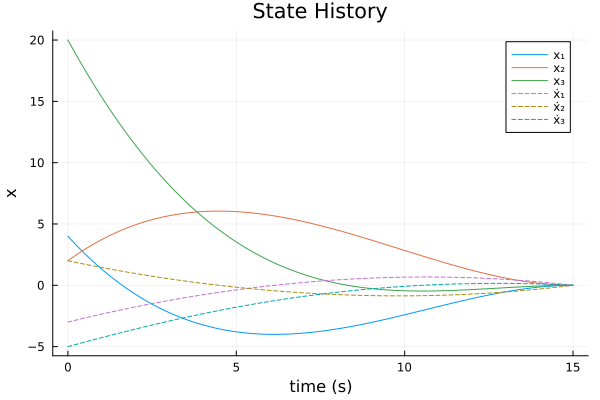

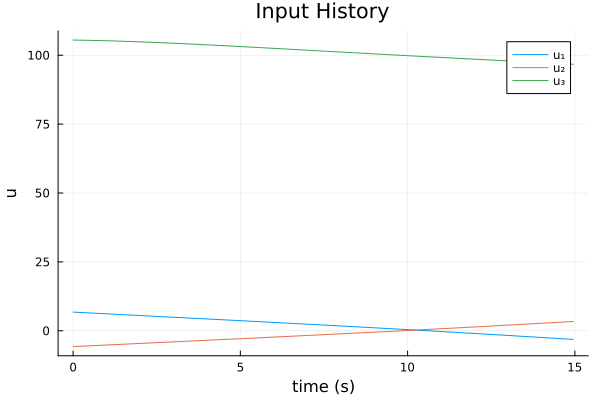

In [145]:
# Let's solve
include("mpc_JuMP.jl")

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 1e0  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# X = Xref*1
# U = Uref*1
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

include("mpc_JuMP.jl")
optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-4,
    "eps_rel"=>1e-4,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
# trajopt_JuMP(optimizer, params, Xn, Un, A, B, f; warm_start=true)
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation (done)
- Scaling between conic constraints and other ones (1/rho, Zac did not buy it)
- Solution polishing?

Maybe, we don't care about TrajOpt problem, except from a good initial guess, there is nothing we can tune to get better performance. How about reset mpc?

In [138]:
# Check conic violation
convio = 0.0
for k = 1:30
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

In [142]:
### MPC style with other solver ###
include("mpc_JuMP.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 100e-1*I(nx)  # make this higher!
R = 1e-1*I(nu)
Qf = 10*I(nx) # change this!
θ_thrust_max = 5.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1e0

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-4,
    "eps_rel"=>1e-4,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
Random.seed!(1);
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    X[1] .= Xhist[i] 
    
    Uhist[i] = mpc_JuMP(optimizer, params1, X, U, A, B, f; warm_start=false)
    
    # X = [Xhist[i] for i = 1:Nh]  # reset, avoid warm-staring
    # U = [-mass * gravity for k = 1:Nh-1]
    # X[1] .= Xhist[i]; Uhist[i] = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-4,max_iters = 10,verbose = false,ρ = 100, ϕ = 10.0) 
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

1. COSMO gives better tracking results
2. Ours always need warm-start

In [143]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

0.0013886049107535436

-7.252078298840628e-5

0.001084801728088738

0.00019480446896369408

0.0014363203908442368

-0.0007051146391978125

0.0008288337841428906

0.0002971867471793936

0.00015397714111452254

-0.00022285613218819833

-0.0009578296598053981

-0.00020027757876306396

-0.00011557271455053808

0.00027486618272528116

0.0003532128196371821

0.0017469719277531937

0.0016761242974503432

0.0022537553787760345

-0.0004635421694771935

-0.8016311170132013

0.0004725901101032548

-0.0029266069788533855

0.00013321452016867852

-0.0002974786679903474

-0.0008174053624649957

-0.00226870799668788

-6.875619904000985e-5

-0.00010001404883652754

-0.000712553696400775

0.0005857234871236017

-0.0011725982944206237

-2.2314620869323676e-5

-0.0004009795780017811

0.0003771692527916315

-4.722725657124727e-5

-0.00039961520029763165

0.00046402687507907103

0.0021373245345426284

3.140642044563435e-5

0.00011620145062707365

0.0007766701637397233

9.125699532752662e-5

-0.0001451689619607066

-0.0006384922922837433

-0.0003250139539012764

0.00026493286180695463

0.0003855389836342482

0.00012514540227925863

0.0002805910120677879

0.0012533925086426478

1.6252955287399118e-5

-0.0003351815335221886

-8.555046134617328e-6

0.0008931193894134992

-0.00023276497090840564

-0.0002611026715424458

0.0008853198244977989

-0.001410386240658923

0.0005869322688774048

-7.308364086355823e-6

8.449512313113416e-5

0.0005947956319989345

-6.908717434939149e-5

-0.00018670223118810725

-4.9693539789785746e-6

-0.00019764179611314603

-0.00010657711010786386

9.979317049157999e-6

-7.394868885768346e-5

-0.00018857271985162072

-0.0005479456639729818

-2.424039711002024e-5

0.0001220901602909663

2.3321834772715988e-5

-0.0013765956503881682

6.061177908911475e-5

6.745757105974803e-5

0.0001911804978043108

0.0001134380751217634

3.704965390483039e-5

-6.300939407566375e-6

0.0006025532477327289

-0.0010946081887066583

-6.266169910063013e-5

-0.0006571976586489114

-9.37966619964925e-5

-0.0005885225504762559

4.249637829722985e-5

0.0003581727027173187

0.001181459420459774

0.00030427131477850367

0.0014008351470069513

0.00045747441793686505

8.687307780341769e-5

5.150056654912305e-5

-0.0001447604000137659

-0.0006802378932988518

0.00012600749331603822

-3.101805222627263e-5

0.0004833567999220634

-1.2962516565906412e-5

-0.0003936316431065734

3.863640175794103e-5

-0.00040068897714196083

0.000846583031364645

4.516802105669626e-5

-0.00012335379290639992

-0.00014244830013687704

-2.5643872698211112e-5

-0.0001691817351829883

-2.719470641920907e-5

-1.3506299406884636e-5

-1.7776975202110634e-5

-3.5409032381750194e-5

-6.133530973606582e-5

-3.3468140209436115e-5

-6.074405638933911e-5

-0.00014592097590515607

-0.00017000215323115242

-0.00017316010523060754

-0.00022456177740348693

-8.628354909490099e-5

8.753305905173647e-5

-3.43286563442291e-5

6.722283224291914e-6

4.27319688540706e-5

-5.25313604988753e-5

9.36193962051135e-5

0.001773210342022935

1.0062392483689564e-6

-0.00027070622701153013

-5.324781326976336e-7

-0.0005602246516698273

-3.242212072152029e-5

0.00013498025600000574

-0.00010888644463236119

2.093319143803285e-5

1.773037351959772e-5

0.00013637681092149023

0.001006919072617407

-0.0009777370878101266

1.1121280044434911e-5

0.0001582171454792558

-0.0001080115854303898

0.0015150279297557745

0.00026012029594291164

0.00048390174352164195

-0.000677670878285852

0.0005601183060388593

1.6974813680903367e-5

-6.143879110354078e-6

-0.0006142391751513543

-7.227181311364461e-5

7.275979321264003e-7

-1.8211561396697107e-6

-0.0002475635620751149

-6.221420713714565e-6

-0.00010850683791829852

7.956091252481201e-6

-3.608669685029042e-5

-2.7400017515333275e-5

-0.00013158077397434909

-1.711702289242112e-5

0.0002161890802145905

0.00028287728059339656

0.00034627131853248727

0.00010684105550318179

0.0008997952491238692

0.0001349400516659216

0.000684032916021593

2.313508225348926e-5

0.0004534544253278483

0.00047225081346446984

-0.0018862818440776863

-2.5564079877874564

-3.25300749255861

-3.4779733876722494

-7.015296966112168

-5.198005828098827

-5.240335931113479

-4.303302489813729

-6.075129099162069

-4.836935633542625

-4.852645937865487

-5.797674864826645

-5.97968965638861

-5.037051420234372

-6.918167509645253

-5.780366232921393

-5.94160617072217

-5.821172571191912

-5.666731051437431

-5.138984872190762

-6.817129681929867

-6.515227134682416

-6.32061034191586

-7.590487906209098

-5.723218895844099

-7.737317855769026

-6.946340623777617

-7.786366297525053

-6.1159416365733845

-6.08787816183679

-6.456994072183411

-6.541433581868033

-7.390797295235961

-5.555568789528954

-7.137906581238658

-8.369789862182618

-6.809299555061531

-7.26209595570443

-8.549559604490378

-7.714918770464647

-7.845780992902772

-7.413179028860051

-6.6556294690314335

-8.358043593771908

-7.340059227087417

-8.20865670122776

-7.494371227928146

-8.337127197288504

-7.709893634405178

-8.43354411841225

-8.40467755202637

-7.042788667076746

-7.818424584957718

-7.280981110498787

-7.849095071161367

-7.277257193984996

-7.388718860578579

-6.958472420706126

-8.535217809562358

-8.357127347277373

-7.94731041341956

-7.368436004955292

-8.052970498156245

-7.370647239460681

-8.186471489402301

-8.151261542395131

-8.415642204550148

-7.777302551395656

-8.269489717921314

-8.163655608089256

-8.174171340323761

-8.445212834622648

-7.443756071540648

-8.538953830174336

-7.594503443920848

-7.466019036317596

-8.44925964042842

-7.926589823499478

-8.348865692237302

-8.25971513758355

-7.911489754223425

-7.430811277838315

-8.205955313598313

-8.535337443194386

-8.571862808927056

-8.504324658952664

-8.489719296148746

-8.14685900500865

-8.511821554926353

-7.455775293410506

-7.134150807068693

-8.521473860180999

-8.109962748584783

-7.830215833979467

-8.229903847095315

-8.035436787822134

-8.249875985968103

-8.089583878678214

-8.285026611943378

-8.15680019893347

-7.672285928848085

-7.912312860248016

-8.213027299785749

-7.75044361451504

-7.95368929725499

-8.269410169087049

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

traj_error = maximum(norm.(e_sim_m, Inf)) = 1.7627148317842982


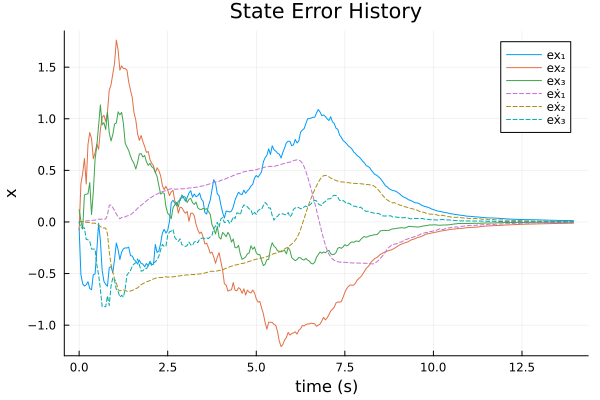

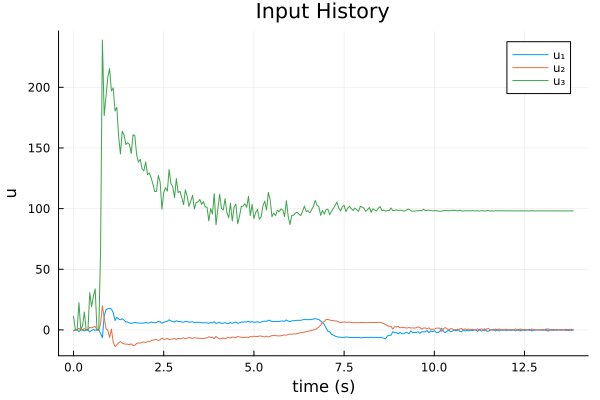

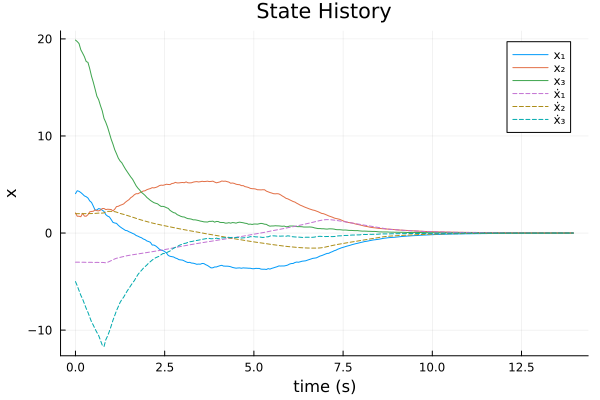

In [144]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))